# Project name: [Predict Future Sales](https://www.kaggle.com/c/competitive-data-science-predict-future-sales)

# Objective

Try new features or Get better than 0.923 score on [Public Leaderboard](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/leaderboard)

# Version

In [3]:
__ver__ = "0.6"

# Setup

In [2]:
import numpy as np
import pandas as pd
import catboost
import xgboost
import sklearn
from sklearn import preprocessing
import matplotlib.pyplot as plt
import statsmodels as sm
from pmdarima import arima
%matplotlib inline 

import itertools
import warnings
import sys

warnings.filterwarnings('ignore')

def downcaster(df):
    for col in df:
        if issubclass(df[col].dtype.type, np.floating):
            df.loc[:, col] = pd.to_numeric(df.loc[:, col], downcast='float')
        if issubclass(df[col].dtype.type, np.integer):
            df.loc[:, col]   = pd.to_numeric(df.loc[:, col], downcast='integer')
    return df

# Data load

In [19]:
# path
cat_path = "./raw_data/item_categories.csv"
items_path = "./raw_data/items.csv"
shop_path = "./raw_data/shops.csv"
sales_path = "./raw_data/sales_train.csv.gz"
test_path = "./raw_data/test.csv.gz"

In [20]:
# load
cat = pd.read_csv(cat_path)
items = pd.read_csv(items_path)
shops = pd.read_csv(shop_path)
sales_params = dict(parse_dates=[0], infer_datetime_format = True, dayfirst=True)
sales = pd.read_csv(sales_path, **sales_params)
prices = pd.read_csv(sales_path, **sales_params)
# load and save ID in index
test = pd.read_csv(test_path).set_index('ID')

# Data preprocessing

 ## Categories

In [5]:
cat.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [6]:
# item_category_name can be split into category_group and sub_category
cat_split = cat.item_category_name.str.split(" - ")
cat["category_group"] = cat_split.apply(lambda x:  x[0].strip())
cat["sub_category"] = cat_split.apply(lambda x:  x[1].strip() if len(x) == 2 else x[0].strip())

In [7]:
# Drop, encode and downcast
cat = cat.drop("item_category_name", axis=1)
cat.category_group = preprocessing.LabelEncoder().fit_transform(cat.category_group)
cat.sub_category = preprocessing.LabelEncoder().fit_transform(cat.sub_category)
cat = downcaster(cat)
cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 3 columns):
item_category_id    84 non-null int8
category_group      84 non-null int8
sub_category        84 non-null int8
dtypes: int8(3)
memory usage: 332.0 bytes


## Shops

In [8]:
# looks like dublicated shops 
shops.iloc[[0, 57, 1, 58, 10, 11]]

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
57,"Якутск Орджоникидзе, 56",57
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58
10,Жуковский ул. Чкалова 39м?,10
11,Жуковский ул. Чкалова 39м²,11


#### Shops 0 and 57

In [9]:
# shop 0 ends at 1 date_block_num               
sales[sales.shop_id == 0].date_block_num.unique()

array([0, 1])

In [10]:
# shop 57 starts at 2 date_block_num
sales[sales.shop_id == 57].date_block_num.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [11]:
# no shop 0 in test set
0 in test.shop_id.unique()

False

In [12]:
# replace shop 0 with 57
sales.loc[sales.shop_id == 0, "shop_id"] = 57

#### Shops 1 and 58

In [13]:
# shop 1 ends at 1 date_block_num               
sales[sales.shop_id == 1].date_block_num.unique()

array([0, 1])

In [14]:
# shop 58 starts at 2 date_block_num
sales[sales.shop_id == 58].date_block_num.unique()

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33])

In [15]:
# no shop 1 in test set
1 in test.shop_id.unique()

False

In [16]:
# replase shop 0 with 58
sales.loc[sales.shop_id == 1, "shop_id"] = 58

#### Shops 10 and 11

In [17]:
# shop 11 exists only at 25 date_block_num
sales[sales.shop_id == 11].date_block_num.unique()

array([25])

In [18]:
# no 25 date_block_num for shop 10
sales[sales.shop_id == 10].date_block_num.unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 26, 27, 28, 29, 30, 31, 32, 33])

In [19]:
# no shop 11 in test set
11 in test.shop_id.unique()

False

In [20]:
# replase shop 11 with 10
sales.loc[sales.shop_id == 11, "shop_id"] = 10

In [21]:
# drop bad shops
shops.drop([0, 1, 11], inplace=True)

#### Shops featues

In [22]:
# First part of shop_name is city
shops.shop_name.str.split().apply(lambda x: x[0]).unique()

array(['Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж', 'Выездная',
       'Жуковский', 'Интернет-магазин', 'Казань', 'Калуга', 'Коломна',
       'Красноярск', 'Курск', 'Москва', 'Мытищи', 'Н.Новгород',
       'Новосибирск', 'Омск', 'РостовНаДону', 'СПб', 'Самара', 'Сергиев',
       'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Цифровой', 'Чехов',
       'Якутск', 'Ярославль'], dtype=object)

In [23]:
shops['city'] = shops.shop_name.str.split().apply(lambda x: x[0].strip())

In [24]:
# Drop, encode and downcast
shops.drop("shop_name", axis=1, inplace=True)
shops.city = preprocessing.LabelEncoder().fit_transform(shops.city)
shops = downcaster(shops)
shops.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57 entries, 2 to 59
Data columns (total 2 columns):
shop_id    57 non-null int8
city       57 non-null int8
dtypes: int8(2)
memory usage: 570.0 bytes


## Items

In [25]:
# Drop, encode and downcast
items.drop("item_name", axis=1, inplace=True)
items = downcaster(items)
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 2 columns):
item_id             22170 non-null int16
item_category_id    22170 non-null int8
dtypes: int16(1), int8(1)
memory usage: 65.0 KB


## Make sales like Test

We use cliped item_cnt - no need to remove outliers.

In [26]:
# Aggregate
state_columns = ["date_block_num", "shop_id", "item_id"]
sales.drop("item_price", axis=1, inplace=True)
sales = sales.groupby(state_columns, as_index=False).sum()

In [27]:
# Rename target
new_columns = sales.columns.tolist()
new_columns[-1] = "y"
sales.columns = new_columns

In [28]:
# Test set consists of 5100 items for 42 shops
(
    len(test.item_id.unique()), 
    len(test.shop_id.unique()), 
    len(test.item_id.unique()) * (len(test.shop_id.unique())) == len(test)
)

(5100, 42, True)

In [29]:
# Sale set consists of 21807 items for 60 shops
len(sales.item_id.unique()), len(sales.shop_id.unique())

(21807, 57)

In [30]:
# There are new items in test set
len(set(test.item_id.unique()) - set(sales.item_id.unique()))

363

In [31]:
# Try drop some shops and items from sales set and add new items to make both sets similar
test_combinations = itertools.product(
    sales.date_block_num.unique(),
    test.shop_id.unique(),
    test.item_id.unique()
)
data = pd.DataFrame(
    list(test_combinations),
    columns=state_columns
)
data = data.merge(sales, on=state_columns, how="left")
data.y = data.y.fillna(0)

In [32]:
# downcast and clip to [0, 20]
data.loc[:, "y"] = data.y.clip(0, 20)
data = downcaster(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7282800 entries, 0 to 7282799
Data columns (total 4 columns):
date_block_num    int8
shop_id           int8
item_id           int16
y                 float32
dtypes: float32(1), int16(1), int8(2)
memory usage: 111.1 MB


## Stack Sales and Test

In [33]:
# add date_block_num to test
test_date_block = data.date_block_num.max() + 1
test["date_block_num"] = test_date_block
test = downcaster(test)

In [34]:
# stack train and test data
data = pd.concat([data, test], axis=0, sort=False)

## Merge all data

In [35]:
data = data.merge(shops, how="left", on="shop_id")
data = data.merge(items, how="left", on="item_id")
data = data.merge(cat, how="left", on="item_category_id")

# Feature generation

## Seasonality

In [36]:
montly_agg = data.groupby("date_block_num")["y"].sum().iloc[:-1]

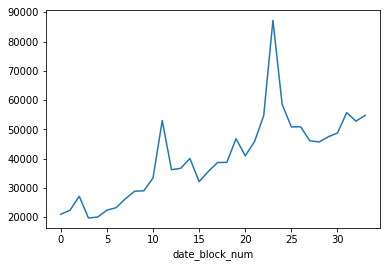

In [37]:
# Seasonality
montly_agg.plot()

In [38]:
# Add month feature
data["month"] = data.date_block_num % 12

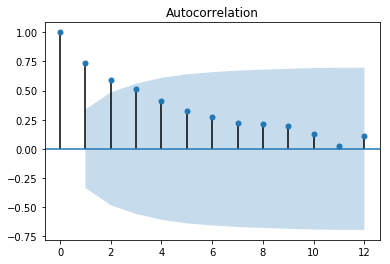

In [39]:
_ = sm.graphics.tsaplots.plot_acf(montly_agg, lags=12)

In [40]:
def make_lags(df, lag_col_name, lags):
    for i in sorted(lags):
        lagger = df[state_columns + [lag_col_name]]
        lagger.loc[:, "date_block_num"] += i
        lagger.columns = lagger.columns[:-1].tolist() + [f"{lag_col_name}_{i}"]
        df = df.merge(lagger, on=state_columns, how='left')
    return df

In [41]:
# Add some first lags and year ago
data = make_lags(data, "y", [1, 2, 3, 4, 13])

In [42]:
# Weak sign of unit root
sm.tsa.stattools.adfuller(montly_agg)

(-2.132157497160812,
 0.23178200425279727,
 0,
 33,
 {'1%': -3.6461350877925254,
  '5%': -2.954126991123355,
  '10%': -2.6159676124885216},
 491.5327212008761)

In [43]:
# Add first diff an year diff
data["diff_y1_y2"] = data["y_1"] - data["y_2"]
data["diff_y1_y13"] = data["y_1"] - data["y_13"]
data.drop("y_13", axis=1, inplace=True)

## Leaks

### We are asked about sellable items

In [44]:
# was this item sold at given date?
tmp = data.groupby(["item_id", "date_block_num"], as_index=False).agg({"y": "max"})
tmp["item_sold"] = tmp.y > 0
tmp.drop("y", axis=1, inplace=True)

In [45]:
# let's guess we make prediction for sellable items
tmp.loc[tmp.date_block_num == tmp.date_block_num.max(), "item_sold"] = True

In [46]:
# add feature
data = data.merge(tmp, how='left', on=["item_id", "date_block_num"])

### Let's mark new items for every date_block_num

In [47]:
# get new items for every date_block_num
new_matrix = []
old_items = set()
for num in sorted(sales.date_block_num.unique()):
    date_items = set(sales[sales.date_block_num == num].item_id.unique())
    if not num:
        old_items = date_items
        continue
    new_items = date_items - old_items
    new_matrix.extend(
        itertools.product(
            [num],
            new_items
        )
    )
    old_items |= date_items

In [48]:
# guess new items for test
new_items = set(test.item_id.unique()) - old_items
new_matrix.extend(
    itertools.product(
        [test_date_block],
        new_items
    )
)

In [49]:
# make feature
tmp = pd.DataFrame(new_matrix, columns=["date_block_num", "item_id"])
tmp["new_item"] = True

In [50]:
data = data.merge(tmp, how='left', on=["item_id", "date_block_num"])
data["new_item"] = data["new_item"].fillna(False)

## Add some proxi sales mean encoded features

### Mean for every item and date

In [51]:
tmp = data.groupby(["item_id", "date_block_num"], as_index=False).y.mean()
tmp.columns = tmp.columns.tolist()[:-1] + ["item_date_y"]
data = data.merge(tmp, on=["item_id", "date_block_num"], how='left')

In [52]:
# Add some laggs and drop column
data = make_lags(data, "item_date_y", [1, 2, 3])
data.drop("item_date_y", axis=1, inplace=True)

### Mean for shop and date

In [53]:
tmp = data.groupby(["shop_id", "date_block_num"], as_index=False).y.mean()
tmp.columns = tmp.columns.tolist()[:-1] + ["shop_date_y"]
data = data.merge(tmp, on=["shop_id", "date_block_num"], how='left')

In [54]:
# Add some laggs and drop column
data = make_lags(data, "shop_date_y", [1, 2, 12])
data.drop("shop_date_y", axis=1, inplace=True)

### Mean for shop, category and date

In [55]:
tmp = data.groupby(["shop_id", "item_category_id", "date_block_num"], as_index=False).y.mean()
tmp.columns = tmp.columns.tolist()[:-1] + ["shop_cat_date_y"]
data = data.merge(tmp, on=["shop_id", "item_category_id", "date_block_num"], how='left')

In [56]:
# Add some laggs and drop column
data = make_lags(data, "shop_cat_date_y", [1, 2, 3])
data.drop("shop_cat_date_y", axis=1, inplace=True)

### Mean for category and date

In [57]:
tmp = data.groupby(["item_category_id", "date_block_num"], as_index=False).y.mean()
tmp.columns = tmp.columns.tolist()[:-1] + ["cat_date_y"]
data = data.merge(tmp, on=["item_category_id", "date_block_num"], how='left')

In [58]:
# Add some laggs and drop column
data = make_lags(data, "cat_date_y", [1, 2, 3])
data.drop("cat_date_y", axis=1, inplace=True)

### Cummean shop and item

In [59]:
tmp = data.groupby(["shop_id", "item_id"])[["y"]].cumsum()
tmp.columns = ["cummean_shop_item_y"]
tmp["date_block_num"] = data["date_block_num"] + 1
tmp["cummean_shop_item_y"] = tmp["cummean_shop_item_y"] / tmp["date_block_num"]
tmp["shop_id"] = data["shop_id"]
tmp["item_id"] = data["item_id"]
data = data.merge(tmp, on=["shop_id", "item_id", "date_block_num"], how='left')

## Prices

In [60]:
# I am going to use log prices - so should remove negative price
prices[prices.item_price <=0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,2013-05-15,4,32,2973,-1.0,1.0


In [61]:
# drop negative price and unused columns
prices.drop(484683, inplace=True)
prices.drop(["date", "item_cnt_day"], axis=1, inplace=True)

In [62]:
# take log
prices.item_price = prices.item_price.apply(np.log)

In [63]:
# let's aggregate with more robust median and downcast
prices = downcaster(prices.groupby(state_columns, as_index=False).median())

In [64]:
# add to data
data = data.merge(prices, on=state_columns, how='left')

### Price discount in shop

In [65]:
# add median of all shops
tmp = data.groupby(["item_id", "date_block_num"]).item_price.median()
tmp.name = "avr_price"
data = data.merge(tmp.to_frame(), left_on=["item_id", "date_block_num"], right_index=True, how='left')

In [66]:
# add discont
data["price_discount"] = data.item_price - data.avr_price
data["price_discount"] = data["price_discount"].fillna(0)

In [67]:
# lag it
data = make_lags(data, "price_discount", [1])
data.drop("price_discount", axis=1, inplace=True)

### Price growth

In [68]:
price_lags = [1, 2, 3, 5, 6]

In [69]:
data = make_lags(data, "avr_price", price_lags)
data.drop(["item_price", "avr_price"], axis=1, inplace=True)

In [70]:
for i in price_lags:
    if i == 1:
        continue
    data[f"price_growth_1_{i}"] = data["avr_price_1"] - data[f"avr_price_{i}"]
    data[f"price_growth_1_{i}"] = data[f"price_growth_1_{i}"].fillna(0)
    data.drop(f"avr_price_{i}", axis=1, inplace=True)
data.drop("avr_price_1", axis=1, inplace=True)

# Save processed data

In [71]:
# drop data with NaN in lags
data.dropna(subset=list(set(data.columns) - set("y")), inplace=True)
# Drop bad features
data.drop(["city"], axis=1, inplace=True)

In [73]:
processed_path = f"./processed_data/data_{__ver__}.pickle"
data.to_pickle(processed_path)

# Load processed data

In [6]:
processed_path = f"./processed_data/data_{__ver__}.pickle"
data = pd.read_pickle(processed_path)

# Validation strategies

Validation strategy:

* Train - all months except last one in the training set
* Validate - a last month in the training set
* Test - a test set

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4712400 entries, 2784600 to 7496999
Data columns (total 34 columns):
date_block_num         int8
shop_id                int8
item_id                int16
y                      float32
item_category_id       int8
category_group         int8
sub_category           int8
month                  int8
y_1                    float32
y_2                    float32
y_3                    float32
y_4                    float32
diff_y1_y2             float32
diff_y1_y13            float32
item_sold              bool
new_item               bool
item_date_y_1          float32
item_date_y_2          float32
item_date_y_3          float32
shop_date_y_1          float32
shop_date_y_2          float32
shop_date_y_12         float32
shop_cat_date_y_1      float32
shop_cat_date_y_2      float32
shop_cat_date_y_3      float32
cat_date_y_1           float32
cat_date_y_2           float32
cat_date_y_3           float32
cummean_shop_item_y    float32
price_di

In [10]:
val_range = 1
test_date_block = data.date_block_num.max()

x_train = data[data.date_block_num < test_date_block - val_range].drop("y", axis=1)
y_train = data.loc[data.date_block_num < test_date_block - val_range, "y"]

mask = (test_date_block - val_range <= data.date_block_num) & (data.date_block_num < test_date_block)
x_valid = data[mask].drop("y", axis=1)
y_valid = data.loc[mask, "y"]

x_test = data[data.date_block_num == test_date_block].drop("y", axis=1)

In [26]:
cat_columns = [i for i, col in enumerate(x_train) if not issubclass(x_train[col].dtype.type, np.floating)]
cat_columns

[0, 1, 2, 3, 4, 5, 6, 13, 14]

# Catboost

I tried base parameters and then use hyper_catboost.py to optimise them - the result was pretty much the same. So I will use default parameters.

**Public Leaderboard:** - 0.93440

In [ ]:
clf_params = dict(
    random_state=284704,
    od_type="Iter",
    od_wait=20,
    verbose=10,
    learning_rate=0.1,
    iterations=200,
)

clf = catboost.CatBoostRegressor(**clf_params)

fit_params = dict(
    X=x_train, 
    y=y_train,
    cat_features=cat_columns,
    eval_set=(x_valid, y_valid),
    plot=True
)

clf.fit(**fit_params)

In [ ]:
# 0.816
for i, v in clf.get_feature_importance(prettified=True):
     print(i.ljust(20), v)

In [ ]:
for i, j, value in clf.get_feature_importance(fstr_type="Interaction", prettified=True)[:10]:
    print(x_train.columns[i].ljust(20), x_train.columns[j].ljust(20), value)

# Base XGBoost

In [24]:
clf_params = dict(
    random_state=284704,
    learning_rate=0.1,
    n_estimators=200,
    max_depth=8,
    min_child_weight=300, 
)
clf = xgboost.XGBRegressor(**clf_params)

clf.fit(
    x_train, 
    y_train, 
    eval_metric="rmse", 
    early_stopping_rounds=20,
    eval_set=[(x_train, y_train), (x_valid, y_valid)], 
    verbose=10)

[0]	validation_0-rmse:1.07739	validation_1-rmse:1.06319
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[10]	validation_0-rmse:0.790228	validation_1-rmse:0.844043
[20]	validation_0-rmse:0.728914	validation_1-rmse:0.817367
[30]	validation_0-rmse:0.709088	validation_1-rmse:0.813437
[40]	validation_0-rmse:0.701002	validation_1-rmse:0.815606
[50]	validation_0-rmse:0.695958	validation_1-rmse:0.81551
Stopping. Best iteration:
[30]	validation_0-rmse:0.709088	validation_1-rmse:0.813437



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=300, missing=None, n_estimators=200,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=284704,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

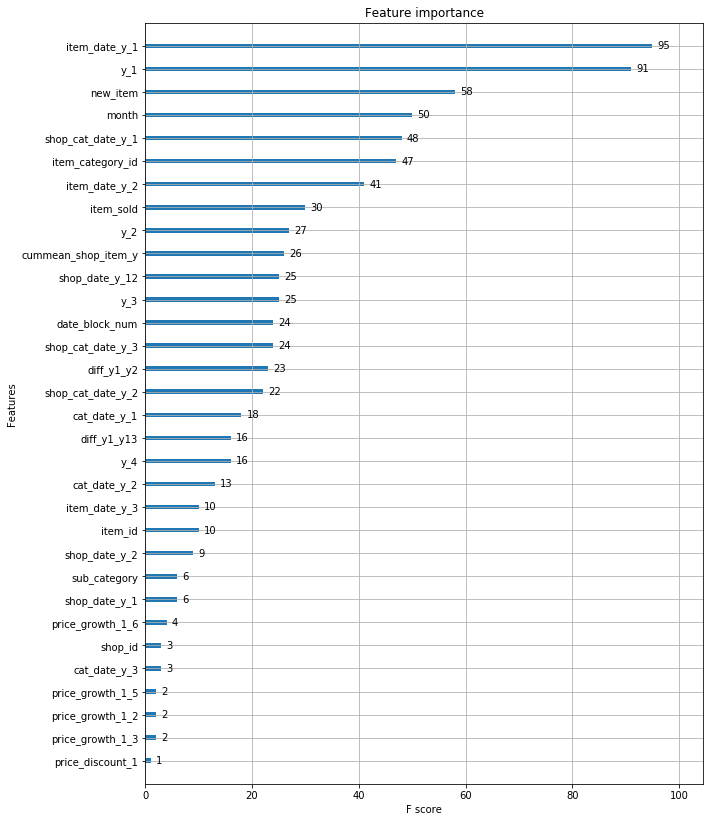

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(10, 14))
xgboost.plot_importance(clf_dart, ax=ax)

**Results:**

Public Leaderboard (base params) - base: 0.95460

# Submission

In [21]:
sub_df = pd.DataFrame(
    clf.predict(x_test), 
    index=test.index, 
    columns=["item_cnt_month"]
).clip(0, 20)
sub_df.index.name = "ID"

In [22]:
sub_path = f"./submissions/submission_{__ver__}.csv"
sub_df.to_csv(sub_path)

## Hyperparameters tuning

Only if you don’t have any more ideas or you have spare computational resources

Average everything:

* Over random seed
* Or over small deviations from optimal parameters

## Ensembling

* Save all good models
* Make diverse models

* Averaging
* Weighted averaging
* Bagging (BaggingClassifier and BaggingRegressor from Sklearn, seed bagging)
* Boosting (AdaBoostClassifier from Sklearn)
* Stacking (Meta model should be modest)
* StackNet
    - Diversity of base algoritms
    - Diversity of base data
    - Simpler algoritms on higher levels
    - Feature engineering of meta feature (differences, std ...)
    - For every level 1model for 5-10 modelesin orivios level